# Improve Changepoint KDE

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append('../')

In [4]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [5]:
from eval.tsdr import load_tsdr_by_chaos

target_metric_types = {
    "services": True,
    "containers": True,
    "middlewares": True,
    "nodes": False,
}
dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types=target_metric_types,
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
)

In [6]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "carts")][3]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

carts/pod-cpu-hog/9n6mf-4


((180, 187),
 '2023-02-17-argowf-chaos-9n6mf-carts_pod-cpu-hog_4.json of carts/pod-cpu-hog')

In [7]:
cause_container_cols = [record.pk.get_service_by_metric(metric) == record.pk.get_service_by_container(record.chaos_comp()) for metric in dataset.columns]
cause_dataset = dataset.loc[:, cause_container_cols]

In [105]:
comp_to_metrics_df = {}
series = dataset
for service, containers in record.pk.get_containers_of_service().items():
    metrics_dfs: list[pd.DataFrame] = []

    service_metrics_df = series.loc[
        :, series.columns.str.startswith(f"s-{service}_")
    ]
    if len(service_metrics_df.columns) > 0:
        metrics_dfs.append(service_metrics_df)

    for container in containers:
        container_metrics_df = series.loc[
            :,
            series.columns.str.startswith(
                (f"c-{container}_", f"m-{container}_")
            ),
        ]
        if len(container_metrics_df.columns) > 0:
            metrics_dfs.append(container_metrics_df)

    if len(metrics_dfs) > 0:
        comp_to_metrics_df[service] = pd.concat(metrics_dfs, axis=1)

In [106]:
cause_dataset

,c-carts_network_receive_packets_total,c-carts_network_transmit_packets_total,c-carts_network_transmit_bytes_total,c-carts_memory_rss,c-carts_memory_cache,c-carts_memory_usage_bytes,c-carts_cpu_system_seconds_total,c-carts_cpu_usage_seconds_total,c-carts_cpu_cfs_periods_total,c-carts_memory_max_usage_bytes,...,c-carts-db_fs_reads_bytes_total,c-carts-db_fs_writes_bytes_total,c-carts-db_threads,c-carts-db_fs_writes_total,c-carts-db_cpu_cfs_throttled_seconds_total,c-carts-db_cpu_user_seconds_total,c-carts-db_memory_working_set_bytes,c-carts-db_network_receive_bytes_total,s-carts_throughput,s-carts_latency
0,1444.7103,1489.9559,251938.3501,659214336.0,11083776.0,677707776.0,0.0940,0.4687,10.0000,691159040.0,...,0.0,98396.3181,133.0,19.0331,0.0008,0.1957,165023744.0,172344.8017,138.3556,0.0054
1,1428.6961,1474.4959,248393.4006,659214336.0,11083776.0,677654528.0,0.0945,0.4711,9.9962,691159040.0,...,0.0,72010.0150,133.0,14.0562,0.0000,0.1406,165023744.0,172204.5118,138.5778,0.0053
2,1438.6575,1483.1717,249977.3911,659214336.0,11083776.0,677654528.0,0.0749,0.3684,7.7108,691159040.0,...,0.0,112959.2326,133.0,20.2093,0.0006,0.1945,164958208.0,173042.1965,138.8667,0.0053
3,1437.7176,1480.8654,249823.6084,659214336.0,11083776.0,677658624.0,0.0996,0.4966,10.0111,691159040.0,...,0.0,113424.4501,133.0,20.1025,0.0005,0.1986,164941824.0,174081.0099,139.3778,0.0052
4,1446.1597,1489.2244,251233.3648,659214336.0,11083776.0,677707776.0,0.1011,0.5035,10.0036,691159040.0,...,0.0,68198.4000,133.0,12.6500,0.0007,0.1320,164941824.0,119496.8836,139.5333,0.0053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1441.0058,1506.8105,253278.8761,663674880.0,13381632.0,685654016.0,0.1202,1.5514,10.0178,691388416.0,...,0.0,101959.4871,133.0,19.5882,0.0396,0.2086,175706112.0,149165.5441,131.3111,0.0101
176,1067.0757,1118.8478,188538.9278,663674880.0,13381632.0,685649920.0,0.1185,1.5574,10.0111,691388416.0,...,0.0,93711.5152,133.0,18.6869,0.0320,0.1997,177483776.0,180548.8779,130.6889,0.0102
177,1414.9931,1483.3589,249827.0277,663674880.0,13381632.0,685604864.0,0.1142,1.5591,10.0042,691388416.0,...,0.0,104796.2903,133.0,19.7617,0.0220,0.1968,178290688.0,177547.9037,130.5333,0.0094
178,1429.8537,1500.7741,253031.0185,663674880.0,13381632.0,685780992.0,0.0904,1.2875,8.2698,691388416.0,...,0.0,101781.3145,133.0,19.3966,0.0192,0.1938,176267264.0,145115.7841,131.4667,0.0093


In [8]:
from tsdr.multireducer import change_point_clustering, change_point_clustering_with_kde
from tsdr.clustering.changepoint import detect_univariate_changepoints, cluster_multi_changepoints
from eval.groundtruth import check_cause_metrics

cinfo, remove_metrics = change_point_clustering_with_kde(
    cause_dataset,
    search_method="binseg",
    cost_model="l2",
    penalty="bic",
    kde_bandwidth="scott",
    multi_change_points=True,
    representative_method=False,
    n_jobs=-1,
)
keep_metrics = list(cinfo.keys())
print(keep_metrics)

check_cause_metrics(record.pk, keep_metrics, chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(), optional_cause=False)


['c-carts-db_memory_cache', 'c-carts_cpu_usage_seconds_total', 's-carts_latency', 'c-carts_memory_max_usage_bytes', 'c-carts_memory_working_set_bytes', 'c-carts_cpu_cfs_throttled_periods_total', 'c-carts_memory_mapped_file', 'c-carts-db_memory_usage_bytes', 'c-carts_memory_rss', 'c-carts-db_cpu_cfs_throttled_seconds_total', 'c-carts_cpu_user_seconds_total', 'c-carts_memory_usage_bytes', 'c-carts_memory_cache', 'c-carts-db_cpu_cfs_throttled_periods_total', 'c-carts_cpu_cfs_throttled_seconds_total', 'c-carts_threads', 's-carts_throughput', 'c-carts_cpu_system_seconds_total']


(True,
 c-carts_cpu_usage_seconds_total,c-carts_cpu_user_seconds_total,c-carts_threads)

In [108]:
# Load raw data
from meltria import loader

raw_record = loader.read_metrics_file(
    "/datasets/argowf-chaos-9n6mf/argowf-chaos-9n6mf/" + record.basename_of_metrics_file(), target_metric_types=target_metric_types, num_datapoints=180, interporate=False)

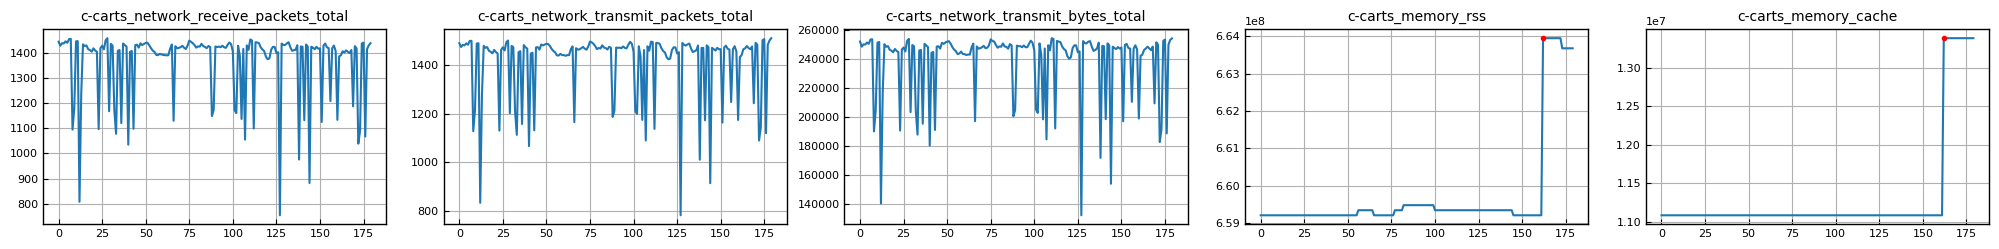

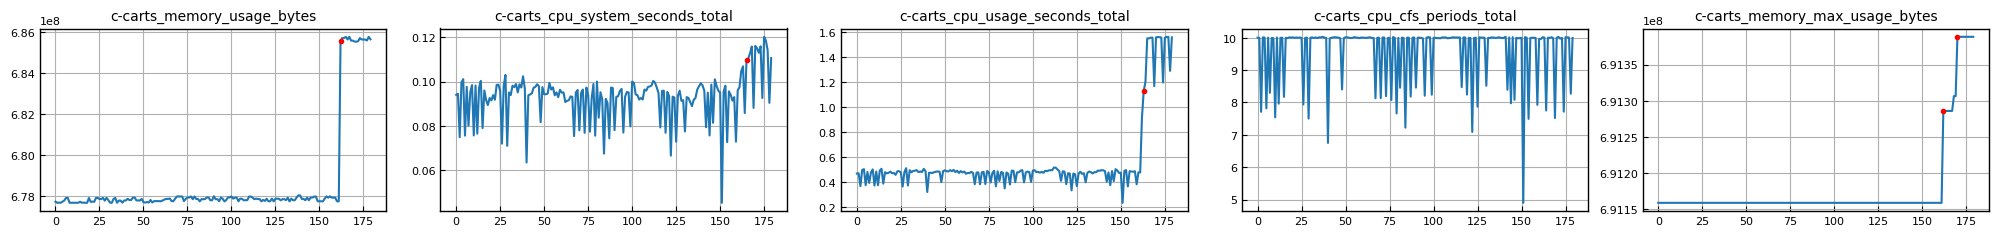

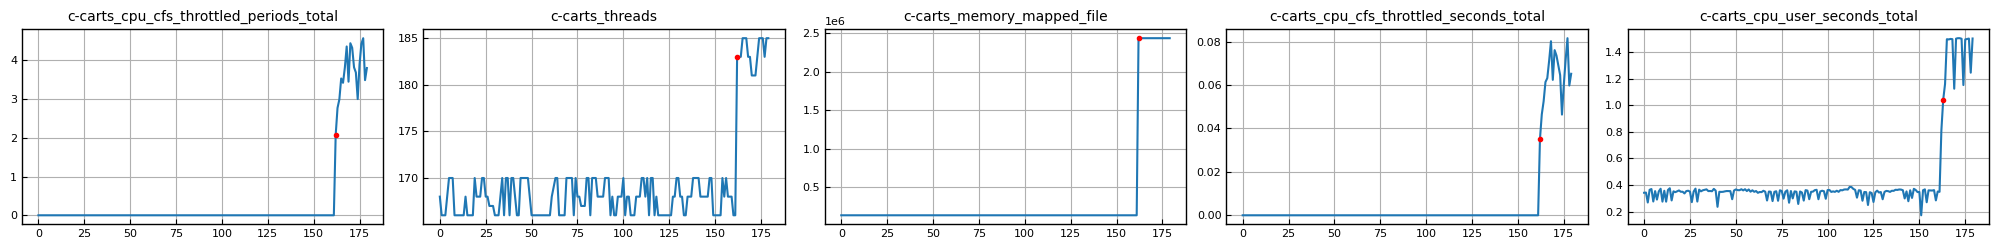

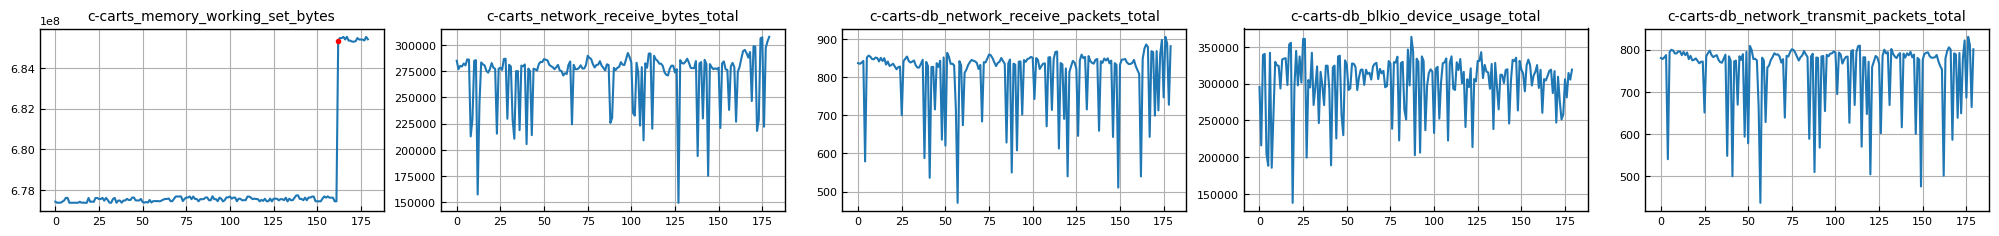

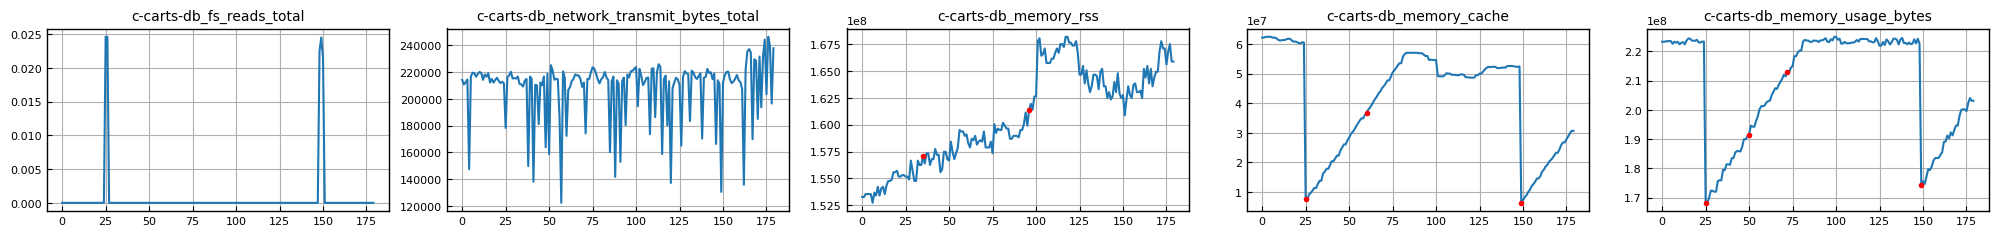

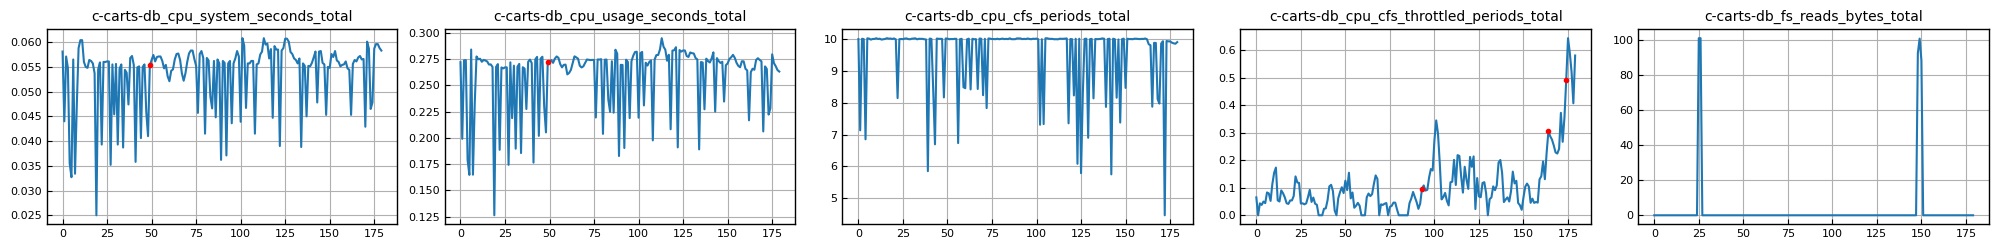

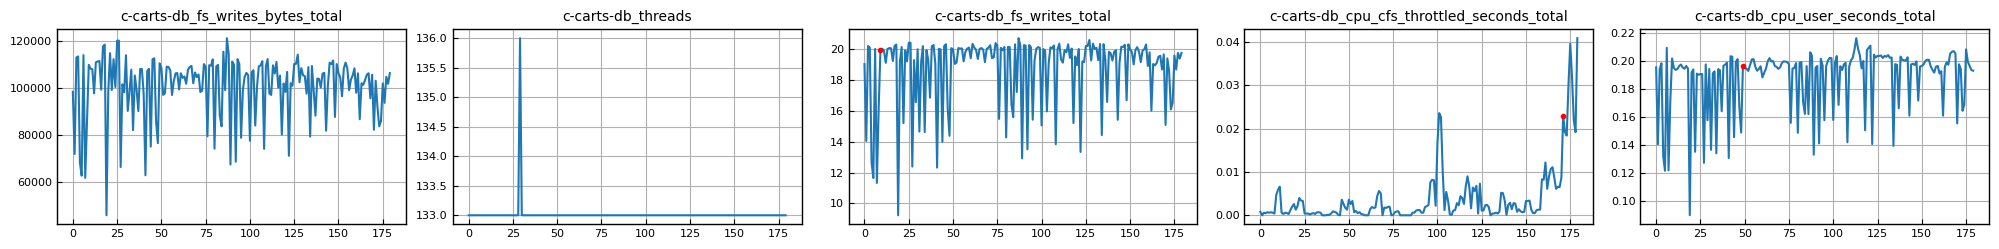

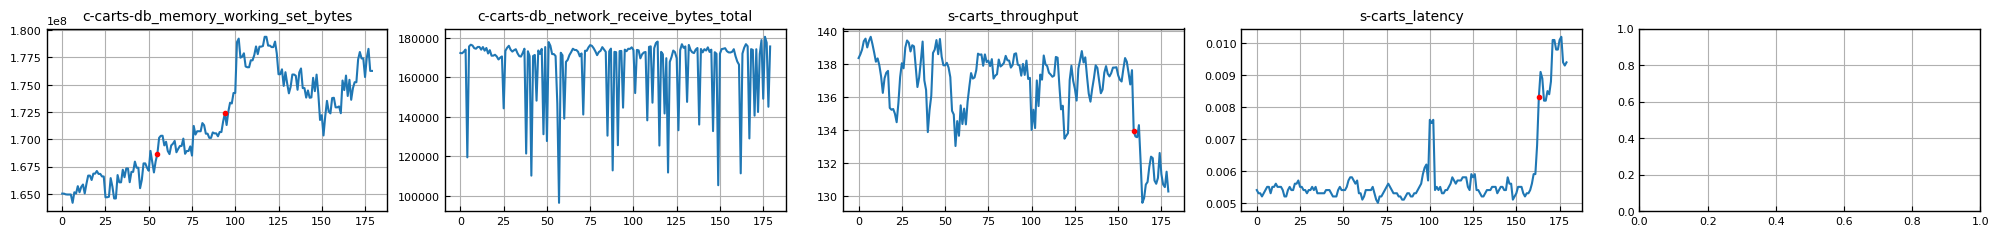

In [11]:
import seaborn as sns

def batch(iterable, n):
    length = len(iterable)
    for i in range(0, length, n):
        yield iterable[i:min(i + n, length)]


multi_changepoints = []
num_per_row = 5
for __metrics in batch(cause_dataset.columns.tolist(), num_per_row):
    fig, axs = plt.subplots(1, num_per_row, figsize=(20, 2.5))
    for __metric, ax in zip(__metrics, axs):
        # x = raw_record.data_df[__metric].to_numpy()
        x = cause_dataset[__metric].to_numpy()
        sns.lineplot(x=range(len(x)), y=x, ax=ax)

        cps = detect_univariate_changepoints(x, search_method="binseg", cost_model="l2", penalty="bic")
        multi_changepoints.append(cps)
        ax.set_title(__metric, fontsize=10)
        if len(cps) > 0:
            ax.plot(cps, x[cps], 'o', color='red', markersize=3)
    fig.tight_layout()
    plt.show()
    fig.clf()
    plt.close(fig=fig)

In [12]:
label_to_metrics, label_to_change_points = cluster_multi_changepoints(
    multi_changepoints, metrics=cause_dataset.columns.tolist(), kde_bandwidth="scott", time_series_length=180)
label_to_metrics, label_to_change_points, {k: len(v) for k, v in label_to_metrics.items()}

(defaultdict(set,
             {0: {'c-carts-db_cpu_cfs_throttled_periods_total',
               'c-carts-db_cpu_system_seconds_total',
               'c-carts-db_cpu_usage_seconds_total',
               'c-carts-db_cpu_user_seconds_total',
               'c-carts-db_fs_writes_total',
               'c-carts-db_memory_cache',
               'c-carts-db_memory_rss',
               'c-carts-db_memory_usage_bytes',
               'c-carts-db_memory_working_set_bytes'},
              1: {'c-carts-db_cpu_cfs_throttled_periods_total',
               'c-carts-db_cpu_cfs_throttled_seconds_total',
               'c-carts-db_memory_cache',
               'c-carts-db_memory_usage_bytes',
               'c-carts_cpu_cfs_throttled_periods_total',
               'c-carts_cpu_cfs_throttled_seconds_total',
               'c-carts_cpu_system_seconds_total',
               'c-carts_cpu_usage_seconds_total',
               'c-carts_cpu_user_seconds_total',
               'c-carts_memory_cache',
         

In [107]:
from collections import defaultdict

NO_CHANGE_POINTS = -1
cp_to_metrics: dict[int, list[str]] = defaultdict(list)
for metric, change_points in zip(cause_dataset.columns, multi_changepoints):
    if len(change_points) < 1:
        cp_to_metrics[NO_CHANGE_POINTS].append(metric)  # cp == -1 means no change point
        continue
    for cp in change_points:
        cp_to_metrics[cp].append(metric)

flatten_change_points: list[int] = sum(multi_changepoints, [])
time_series_length = cause_dataset.shape[0]
x = np.array(flatten_change_points, dtype=int)

### sklearn

[162 162 162 165 163 162 170 162 162 162 162 163 162  35  96  25  60 149
  25  50  72 149  49  49  93 164 174   9 171  49  55  94 159 163] 55.8845278214551 55.8845278214551
KDE bandwidth: 29.261842451945448
0.4939741431709848 scott
29.261842451945448 29.261842451945448


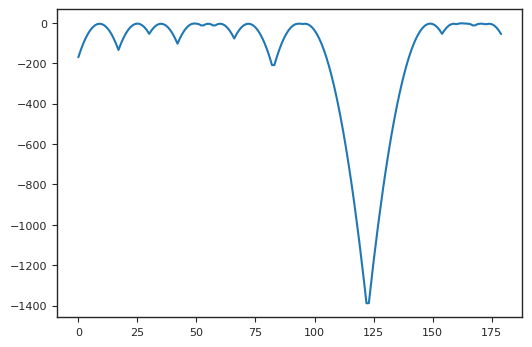

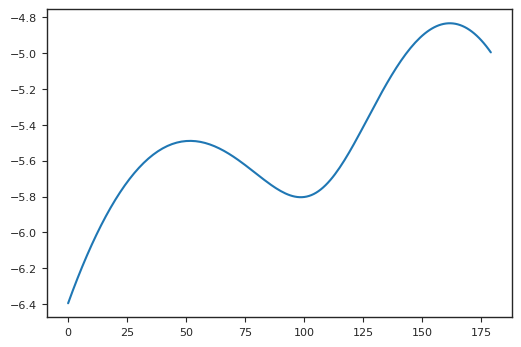

In [110]:
from sklearn.neighbors import KernelDensity
import scipy

kde_bandwidth = "scott"
iqr = np.quantile(x, 0.75) - np.quantile(x, 0.25)
sigma = min(x.std(), iqr / 1.34)
print(x, np.std(x), sigma)
match kde_bandwidth:
    case "silverman":
        kde_bandwidth = 0.9 * sigma * (len(x) ** (-1 / 5.))
    case "scott":
        kde_bandwidth = 1.06 * sigma * (len(x) ** (-1 / 5.))
    case _:
        pass
print(f"KDE bandwidth: {kde_bandwidth}")

kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(x.reshape(-1, 1))
print(kde.bandwidth_, kde.bandwidth)
s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = kde.score_samples(s.reshape(-1, 1))
# e = np.log(kde(s))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)

kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(x.reshape(-1, 1))
print(kde.bandwidth_, kde.bandwidth)
s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = kde.score_samples(s.reshape(-1, 1))
# e = np.log(kde(s))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)

### scipy

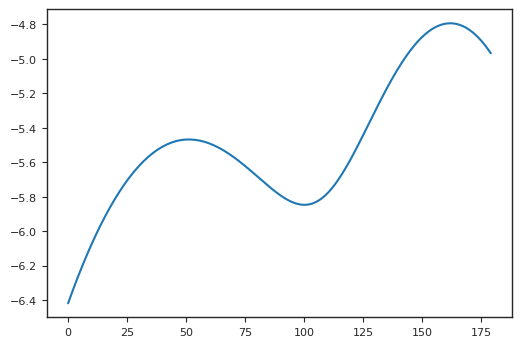

In [115]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(x, bw_method="scott")
s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = kde.logpdf(s)
# e = np.log(kde(s))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)

### statsmodels

29.67387419537256 scott
29.680146368292498 normal_reference
2.967387419537256 scott 0.1


Text(0.5, 1.0, 'adjust=0.1')

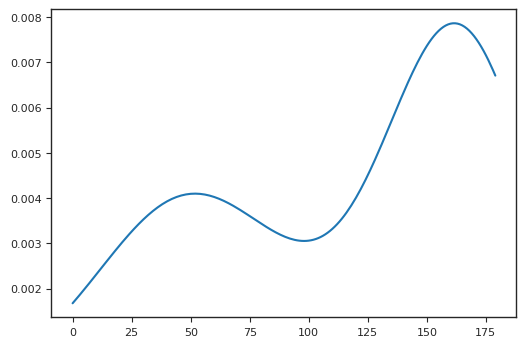

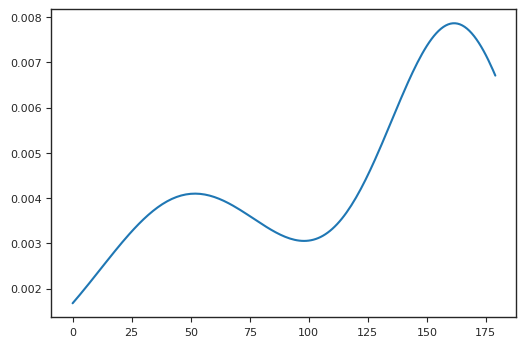

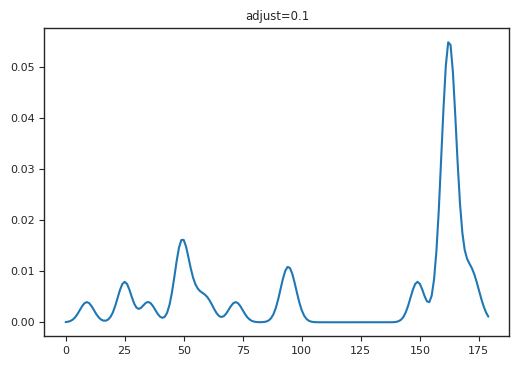

In [140]:
from statsmodels.nonparametric.kde import KDEUnivariate

dens = KDEUnivariate(x)
dens.fit(bw="scott", kernel="gau")
print(dens.bw, dens.bw_method)

s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dens.evaluate(s))


dens = KDEUnivariate(x)
dens.fit(bw="normal_reference", kernel="gau")
print(dens.bw, dens.bw_method)

s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dens.evaluate(s))


adjust = 0.1
dens = KDEUnivariate(x)
dens.fit(bw="scott", kernel="gau", adjust=adjust)
print(dens.bw, dens.bw_method, adjust)

s = np.linspace(start=0, stop=time_series_length - 1, num=time_series_length)  # If 'num' are larger, cluster size will be smaller.
e = dens.evaluate(s)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(e)
ax.set_title(f"adjust={adjust}")

In [141]:
from scipy.signal import argrelextrema

mi = argrelextrema(e, np.less)[0]
clusters = []
if len(mi) <= 0:
    clusters.append(np.arange(len(x)))
else:
    clusters.append(np.where(x < s[mi][0])[0])  # most left cluster
    for i_cluster in range(len(mi) - 1):  # all middle cluster
        clusters.append(np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster + 1]))[0])
    clusters.append(np.where(x >= s[mi][-1])[0])  # most right cluster

labels = np.zeros(len(x), dtype=int)
for label, x_args in enumerate(clusters):
    clusters[label] = np.unique(x[x_args])
    labels[x_args] = label
label_to_values: dict[int, np.ndarray] = {label: vals for label, vals in enumerate(clusters)}
label_to_values

{0: array([9]),
 1: array([25]),
 2: array([35]),
 3: array([49, 50, 55, 60]),
 4: array([72]),
 5: array([93, 94, 96]),
 6: array([149]),
 7: array([159, 162, 163, 164, 165, 170, 171, 174])}

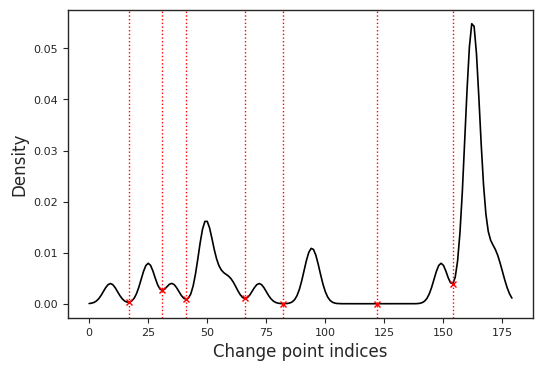

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.set_style("ticks")
sns.lineplot(x=s, y=e, ax=ax, color='black', linewidth=1.2)
ax.plot(s[mi], e[mi], 'x', color='red', markersize=4)
# ax.vlines(x=s[mi], ymin=min(e[mi])-100, ymax=100, color='red', linestyles='dotted', linewidth=1.0)
for v in s[mi]:
    ax.axvline(x=v, color='red', linestyle='dotted', linewidth=1.0) 
ax.set_xlabel("Change point indices", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
fig.savefig("./materials/kde_samples.pdf", format="pdf", dpi=400, bbox_inches="tight")
plt.show()
fig.clf()
plt.close(fig)